In [26]:
# %pip install pandas
# %pip install pyarrow
# %pip install matplotlib
# %pip install statsmodels

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 4.2 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.5 MB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels

pd.options.mode.copy_on_write = True 

In [6]:
df = pd.read_csv('Dataset/Used_data.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Holiday,Profit,Age Group,Month,Year,Year-Month,Income Group
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,non Holiday,57.315,25-29,1,2016,2016-01,8000 - 14999
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,non Holiday,23.666,25-29,1,2016,2016-01,8000 - 14999
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,non Holiday,27.568,50-54,1,2016,2016-01,8000 - 14999
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,non Holiday,25.798,18-24,1,2016,2016-01,22000 - 34999
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536,non Holiday,16.844,30-34,1,2016,2016-01,8000 - 14999


I want to make a profit prediction, from the analysis that has been done previously, I will use the time series. The profit line plot shows that there is a trend in certain months, therefore, I will use the SARIMA (Seasonal ARIMA) algorithm

<div style="text-align:center">
    <img src="Profit per month.png" alt="Profit per month" style="width:700px;" />
</div>

In [20]:
df_SARIMA = df[['Date of Travel', 'Profit']]
df_SARIMA.head()

,Date of Travel,Profit
0,2016-01-08,57.315
1,2016-01-06,23.666
2,2016-01-02,27.568
3,2016-01-07,25.798
4,2016-01-03,16.844


In [21]:
df_SARIMA.dtypes

Date of Travel     object
Profit            float64
dtype: object

Make the `Date of Travel` as Datetime

In [22]:
df_SARIMA['Date of Travel'] = pd.to_datetime(df_SARIMA['Date of Travel'])
df_SARIMA.dtypes

Date of Travel    datetime64[ns]
Profit                   float64
dtype: object

Set `Date of Travel` to index

In [23]:
df_SARIMA = df_SARIMA.set_index('Date of Travel').reset_index()
df_SARIMA.head()

,Date of Travel,Profit
0,2016-01-08,57.315
1,2016-01-06,23.666
2,2016-01-02,27.568
3,2016-01-07,25.798
4,2016-01-03,16.844


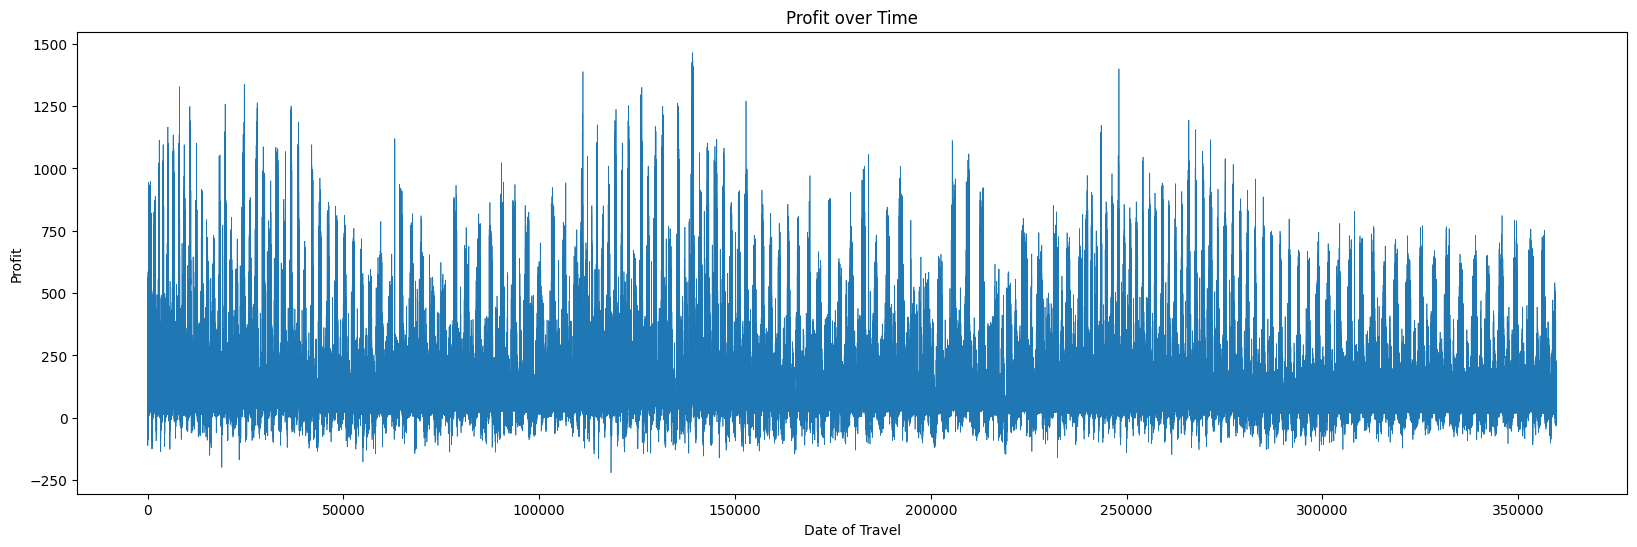

In [40]:
plt.figure(figsize=(20,6))
plt.plot(df_SARIMA.index, df_SARIMA['Profit'], linestyle='-', linewidth=0.5)
plt.title('Profit over Time')
plt.xlabel('Date of Travel')
plt.ylabel('Profit')
plt.show()